# Tutorial 1: Disease diagnosis and biomarker identification

CellFreeGMF leverages machine learning and differential expression analysis to achieve diagnostic classification and biomarker identification for pancreatic ductal adenocarcinoma.

## Preparation

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

In [2]:
import CellFreeGMF

## Hyperparameter Configuration

In [3]:
current_path = os.path.abspath('')
disease_name = 'PDAC'

## Load Data

In [4]:
def read_sample_cfRNA(disease_name = 'PDAC'):
    data_path = current_path + '/data/' + disease_name

    data_exp = pd.read_csv(data_path + '/GSE133684_exp_TPM-all.txt', sep='\t')
    data_exp = data_exp.set_index(data_exp.columns[0]).T

    label_all = pd.read_csv(data_path + '/GSE133684_series_matrix.csv', sep=',')
    
    label_all = label_all.set_index(label_all.columns[0])
    label_all['label'] = label_all[label_all.columns[0]].apply(lambda x: 1 if x == 'disease state: PDAC' else 0)

    # label_all = label_all.loc[data_exp.index]
    data_exp = data_exp.loc[label_all.index]

    data_all = {'data_exp': data_exp,
                'label': label_all}

    return data_all

# standardized matrix
def log_cpm(matrix: pd.DataFrame) -> pd.DataFrame:
    # Rows represent samples, and columns represent cfRNAs.
    matrix = matrix.T
    lib_size = matrix.sum(axis=0)
    cpm = matrix.divide(lib_size, axis=1) * 1e6
    log_cpm = np.log2(cpm + 1)
    return log_cpm.T

# read cfRNA data
sample_cfRNA_exp = read_sample_cfRNA(disease_name)
X_train, X_val, y_train, y_val = train_test_split(sample_cfRNA_exp['data_exp'], sample_cfRNA_exp['label']['label'], test_size=0.2, random_state=2025)

# Differential expression analysis was performed using the limma package.
DEG_res = CellFreeGMF.DEG_limma_fun(X_train, y_train, file_path = current_path + '/save_data/' + disease_name)

X_train = log_cpm(X_train)
X_val = log_cpm(X_val)

R[write to console]: 'select()' returned 1:many mapping between keys and columns



## Diagnostic classification using machine learning was performed.

In [5]:
ML_lr, ML_lr_train, ML_lr_val, ML_lr_roc_ = CellFreeGMF.diagnosis_ML.ML_lr(X_train, y_train, X_val, y_val)
ML_svm, ML_svm_train, ML_svm_val, ML_svm_roc_  = CellFreeGMF.diagnosis_ML.ML_svm(X_train, y_train, X_val, y_val)
ML_rf, ML_rf_train, ML_rf_val, ML_rf_roc_ = CellFreeGMF.diagnosis_ML.ML_rf(X_train, y_train, X_val, y_val)
ML_ada, ML_ada_train, ML_ada_val, ML_ada_roc_ = CellFreeGMF.diagnosis_ML.ML_ada(X_train, y_train, X_val, y_val)
ML_dt, ML_dt_train, ML_dt_val, ML_dt_roc_ = CellFreeGMF.diagnosis_ML.ML_dt(X_train, y_train, X_val, y_val)
ML_knn, ML_knn_train, ML_knn_val, ML_knn_roc_ = CellFreeGMF.diagnosis_ML.ML_knn(X_train, y_train, X_val, y_val)

Logistic Regression:
Training dataset Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC:1.0000
Testing dataset Accuracy: 0.9383, Precision: 0.9387, Recall: 0.9383, F1-Score: 0.9368, AUC:0.9807
****************************************************************************************************
SVM:
Training dataset Accuracy: 0.7250, Precision: 0.8023, Recall: 0.7250, F1-Score: 0.6289, AUC:0.9954
Testing dataset Accuracy: 0.7284, Precision: 0.5306, Recall: 0.7284, F1-Score: 0.6139, AUC:0.9322
****************************************************************************************************
RandomForestClassifier:
Training dataset Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC:1.0000
Testing dataset Accuracy: 0.8642, Precision: 0.8720, Recall: 0.8642, F1-Score: 0.8515, AUC:0.9480
****************************************************************************************************
AdaBoostClassifier:
Training dataset Accuracy: 1.0000, P

## Performance comparison of diagnostic classification algorithms to screen for the algorithm optimally suited to PDAC.

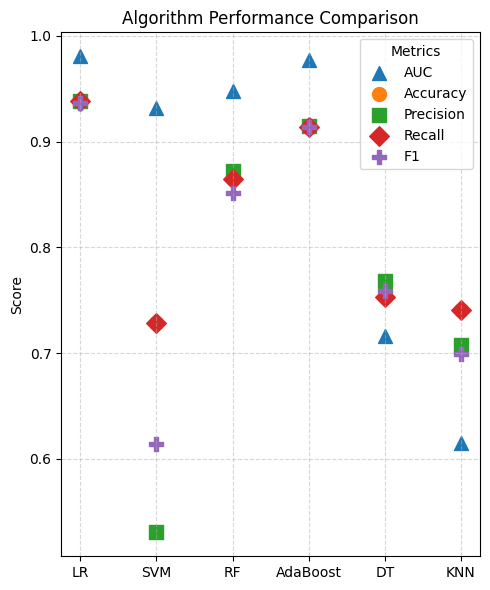

In [6]:
# Algorithm names
algorithms = ['LR', 'SVM', 'RF', 'AdaBoost', 'DT', 'KNN']

# Evaluation metric scores for each algorithm.
metrics = {
    'AUC':      [ML_lr_val['auc_val'], ML_svm_val['auc_val'], ML_rf_val['auc_val'],ML_ada_val['auc_val'], ML_dt_val['auc_val'], ML_knn_val['auc_val']],
    'Accuracy': [ML_lr_val['accuracy_val'], ML_svm_val['accuracy_val'], ML_rf_val['accuracy_val'],ML_ada_val['accuracy_val'], ML_dt_val['accuracy_val'], ML_knn_val['accuracy_val']],
    'Precision':[ML_lr_val['precision_val'], ML_svm_val['precision_val'], ML_rf_val['precision_val'],ML_ada_val['precision_val'], ML_dt_val['precision_val'], ML_knn_val['precision_val']],
    'Recall':   [ML_lr_val['recall_val'], ML_svm_val['recall_val'], ML_rf_val['recall_val'],ML_ada_val['recall_val'], ML_dt_val['recall_val'], ML_knn_val['recall_val']],
    'F1':       [ML_lr_val['f1_val'], ML_svm_val['f1_val'], ML_rf_val['f1_val'],ML_ada_val['f1_val'], ML_dt_val['f1_val'], ML_knn_val['f1_val']]
}

# Assign a distinct marker shape to each evaluation metric.
markers = {
    'AUC': '^',          # triangle
    'Accuracy': 'o',     # circle
    'Precision': 's',    # square
    'Recall': 'D',       # diamond
    'F1': 'P'            # pentagon
}

# plot
plt.figure(figsize=(5, 6))

# The x-axis denotes the algorithms.
x = np.arange(len(algorithms))

# Plot scatter points
for metric, scores in metrics.items():
    plt.scatter(x, scores, label=metric, marker=markers[metric], s=100)

# Set the legend, labels, and axes.
plt.xticks(x, algorithms)
plt.ylabel("Score")
plt.title("Algorithm Performance Comparison")
plt.legend(title="Metrics")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Save as PDF
plt.savefig(current_path + '/save_data/' + disease_name + "/Fig2a.pdf")

plt.show()
plt.close()

## The optimal logistic regression model was selected and subsequently retrained on the full dataset; interpretability analysis was then performed to identify candidate target cfRNAs.

In [7]:
X = sample_cfRNA_exp['data_exp']
ML_lr = CellFreeGMF.diagnosis_ML.ML_lr(sample_cfRNA_exp['data_exp'], sample_cfRNA_exp['label']['label'])

Logistic Regression:
Training dataset Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC:1.0000
****************************************************************************************************


## SHAP-based interpretability analysis

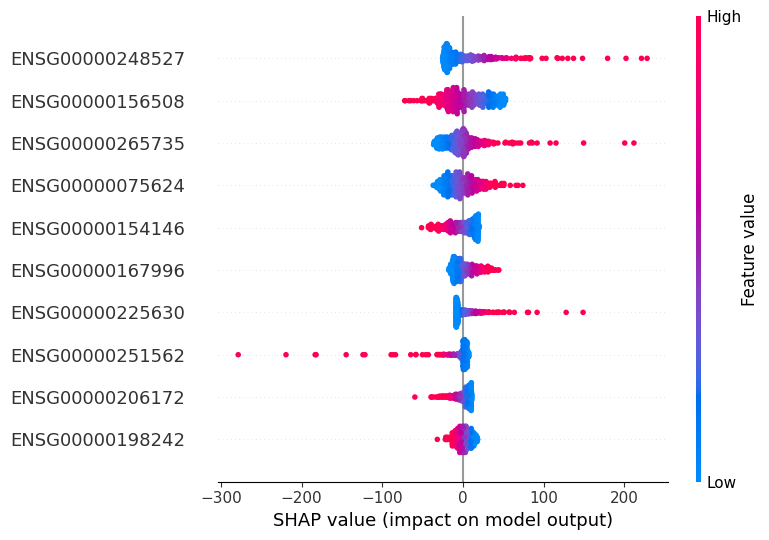

In [8]:
explainer = shap.LinearExplainer(ML_lr, X, feature_names=X.columns)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, feature_names=X.columns, show=False, max_display=10)

# extract feature importance
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean_ABS_SHAP': shap_importance
})

importance_df = importance_df.sort_values(by='Mean_ABS_SHAP', ascending=False)


## Save the differential expression analysis results and the SHAP results.

In [9]:
importance_df.to_csv(current_path + '/save_data/' + disease_name + '/shap_feature_importance.csv', index=False)
DEG_res.to_csv(current_path + '/save_data/' + disease_name + '/DEG_res.csv')